In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime as dt

%run config.ipynb
%run models.ipynb
%run Dataset_preparation.ipynb

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def save_checkpoint(model_dict, extension = "pth"):
    path = os.path.join(checkpoints,f'model_epoch{epoch:03d}.pth')
    
    try:
        torch.save(model_dict, path)
        print("Checkpoint saved successfully")
        
    except BaseException as e:
        print(e)
        print("Failed to save the file, try again !")

In [3]:
def weights_init(m):
    
    classname=m.__class__.__name__
    
    if classname.find('Linear')!=-1:
        y = m.in_features
        m.weight.data.normal_(0.0,1/np.sqrt(y))
        m.bias.data.fill_(0)    
        
    if classname.find('Conv3d')!=-1:
        m.weight.data.normal_(0.0, 0.02)

In [4]:
model=HResNet()
model.to(device)
model.train()

HResNet(
  (spectral): spectral_features(
    (conv1): ConvBlock(
      (conv): Conv3d(1, 24, kernel_size=(1, 1, 5), stride=(1, 1, 2))
      (bn): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2): ConvBlock(
      (conv): Conv3d(6, 6, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (bn): BatchNorm3d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv3): ConvBlock(
      (conv): Conv3d(12, 12, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (bn): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv4): ConvBlock(
      (conv): Conv3d(18, 12, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (bn): BatchNorm3d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv5): ConvBlock(
      (conv): Conv3d(36, 24, 

In [5]:
epochs=200
alpha=0.0002
best_loss=100000
best_model=None
resume=0
parameters=model.parameters()
optimiser=optim.Adam(parameters, lr=alpha)
graph_loss=[]
if len(os.listdir(checkpoints))!=0:
    
    chkpts=os.listdir(checkpoints)
    print(f'Using pretrained version of the model: {chkpts[-1]}')
    current=torch.load(os.path.join(checkpoints,chkpts[-1]), map_location=device)
    model.load_state_dict(current["model_state_dict"])
    resume=current["resume"]
    
    print(f'Resuming from epoch {resume}')
    optimiser.load_state_dict(current['optimiser_state_dict'])
    graph_loss=current["graph_loss"]

else:
    
    model.apply(weights_init)


In [6]:
def cls_loss(output, target):
    
    loss=nn.CrossEntropyLoss()
    _, labels=torch.max(target, dim=1)
    _, pred=torch.max(output, dim=1)
    val=loss(output, labels)
    acc=0
    
    for i in range(labels.shape[0]):
        if labels[i].item()==pred[i].item():
            acc+=1
    
    return acc, val

Epoch 1:
Loss: 2.0982929441663956
Accuracy: 41.82539682539683%
Time elapsed: 0:00:02.823879
Replacing best model
Epoch 10:
Loss: 1.5668860844203405
Accuracy: 91.74603174603175%
Time elapsed: 0:00:15.799813
Replacing best model
Epoch 20:
Loss: 1.4856210012284536
Accuracy: 93.65079365079364%
Time elapsed: 0:00:17.717009
Replacing best model
Epoch 30:
Loss: 1.4596614777095733
Accuracy: 95.23809523809523%
Time elapsed: 0:00:17.551181
Replacing best model
Epoch 40:
Loss: 1.4532943937513563
Accuracy: 95.55555555555556%
Time elapsed: 0:00:17.724354
Replacing best model
Epoch 50:
Loss: 1.442035272386339
Accuracy: 95.95238095238095%
Time elapsed: 0:00:17.811674
Replacing best model
Epoch 60:
Loss: 1.4266857026115296
Accuracy: 97.38095238095238%
Time elapsed: 0:00:18.284979
Replacing best model
Epoch 70:
Loss: 1.4257629697285001
Accuracy: 97.93650793650794%
Time elapsed: 0:00:18.132553
Replacing best model
Epoch 80:
Loss: 1.417119652884347
Accuracy: 97.93650793650794%
Time elapsed: 0:00:18.37640

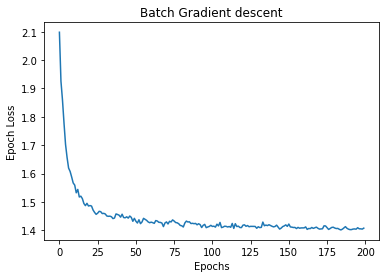

In [7]:
start=dt.datetime.now()
for epoch in range(resume, epochs):
    
    epoch_size=len(dataset)/batch_size
    epoch_loss=0
    acc=0
    for b, (x, y) in enumerate(lo):
        
        x=x.to(device)
        y=y.to(device)
        
        optimiser.zero_grad()
        
        output=model(x)
        flag, loss=cls_loss(output, y)
        acc+=flag
        
        loss.backward()
        optimiser.step()
        
        epoch_loss+=loss.item()
    
    graph_loss.append(epoch_loss/epoch_size)  
    acc=acc/len(dataset)
    if (epoch+1)%10==0 or epoch==0:
        
        end=dt.datetime.now()
        print(f"Epoch {epoch+1}:\nLoss: {epoch_loss/epoch_size}\nAccuracy: {acc*100}%\nTime elapsed: {end-start}")
        if best_loss>epoch_loss/epoch_size:

            print("Replacing best model")
            best_loss=epoch_loss/epoch_size
            best_model=model
        
        if acc>=0.985:
            save_checkpoint({'model_state_dict': model.state_dict(),
                             'epoch': epoch,
                             'loss': epoch_loss,
                             'optimiser_state_dict': optimiser.state_dict(),
                             'graph_loss': graph_loss,
                             'resume': epoch+1,
                            })

        print("="*50)
        start=dt.datetime.now()

plt.plot(graph_loss) 
plt.xlabel("Epochs")
plt.ylabel("Epoch Loss")
plt.title("Batch Gradient descent")

print("Training complete")